In [ ]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
import io

from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Dropout, LSTM, Bidirectional
from keras.models import Model, Sequential

from keras.engine.topology import Layer, InputSpec
from keras import initializers
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import matplotlib.pyplot as plt
%matplotlib inline
plt.switch_backend('agg')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
data_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/labeledTrainData.tsv',sep='\t')
print(data_train.shape)
data_train[0:3]

(25000, 3)


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...


In [ ]:
texts=[]
labels=[]

data_train['review'] = data_train['review'].astype(str).str.replace("\r", " ")
data_train['review'] = data_train['review'].astype(str).str.replace("\n", " ")
data_train['review'] = data_train['review'].astype(str).str.replace("    ", " ")
data_train['review'] = data_train['review'].astype(str).str.replace('"', '')
data_train['review'] = data_train['review'].astype(str).str.replace("\\","")
data_train['review'] = data_train['review'].astype(str).str.replace("\'","")
data_train['review'] = data_train['review'].astype(str).str.replace("\"","")
data_train['review'] = data_train['review'].astype(str).str.lower()

punctuation_signs = list("-()?:!.,;")
for punct_sign in punctuation_signs:
    data_train['review'] = data_train['review'].astype(str).str.replace(punct_sign,"")

data_train.loc[3]['review']


'it must be assumed that those who praised this film the greatest filmed opera ever didnt i read somewhere either dont care for opera dont care for wagner or dont care about anything except their desire to appear cultured either as a representation of wagners swansong or as a movie this strikes me as an unmitigated disaster with a leaden reading of the score matched to a tricksy lugubrious realisation of the text<br /><br />its questionable that people with ideas as to what an opera or for that matter a play especially one by shakespeare is about should be allowed anywhere near a theatre or film studio syberberg very fashionably but without the smallest justification from wagners text decided that parsifal is about bisexual integration so that the title character in the latter stages transmutes into a kind of beatnik babe though one who continues to sing high tenor  few if any of the actors in the film are the singers and we get a double dose of armin jordan the conductor who is seen a

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
nrows = len(data_train)
lemmatized_text_list = []

for row in range(0, nrows):
    lemmatized_list = []
    text = data_train.loc[row]['review']
    text_words = text.split(" ")
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    lemmatized_text = " ".join(lemmatized_list)
    lemmatized_text_list.append(lemmatized_text)
  
data_train['review'] = lemmatized_text_list

In [ ]:
stop_words = list(stopwords.words('english'))
data_train['review'] = data_train['review']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    data_train['review'] = data_train['review'].str.replace(regex_stopword, '')

In [ ]:
for idx in range(data_train.review.shape[0]):
    text = BeautifulSoup(data_train.review[idx],'lxml')
    texts.append(text.get_text())
    labels.append(data_train.sentiment[idx])

texts[3]

'must  assume    praise  film  greatest film opera ever didnt  read somewhere either dont care  opera dont care  wagner  dont care  anything except  desire  appear culture either   representation  wagners swansong    movie  strike    unmitigated disaster   leaden read   score match   tricksy lugubrious realisation   text questionable  people  ideas     opera    matter  play especially one  shakespeare     allow anywhere near  theatre  film studio syberberg  fashionably  without  smallest justification  wagners text decide  parsifal   bisexual integration    title character   latter stag transmute   kind  beatnik babe though one  continue  sing high tenor       actors   film   singers   get  double dose  armin jordan  conductor   see   face   hear   voice  amfortas  also appear monstrously  double exposure   kind  batonzilla  conductor  eat monsalvat   play   good friday music      way  transcendant loveliness  nature  represent   scatter  shopworn  flaccid crocuses stick  illlaid turf 

In [ ]:
tokenizer=Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 113800 unique tokens.


In [ ]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels))
labels = np.asarray(labels, dtype = np.float32)
print('Shape of data tensor: ', data.shape)
print('Shape of label tensor: ',labels.shape)

Shape of data tensor:  (25000, 1000)
Shape of label tensor:  (25000, 2, 2)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print ('Number of negative and positive reviews in training and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Number of negative and positive reviews in training and validation set
[[10042.  9958.]
 [ 9958. 10042.]]
[[2458. 2542.]
 [2542. 2458.]]


In [ ]:
embeddings_index = {}
f=open('/content/drive/My Drive/Colab Notebooks/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index)+1,EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

Total 400000 word vectors in Glove 6B 100d.


In [ ]:
embedding_layer = Embedding(len(word_index) +1,
                    EMBEDDING_DIM,
                    weights = [embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable = True)
sequence_input = sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_bilstm = Bidirectional(LSTM(100))(embedded_sequences)
dropout = Dropout(0.5)(l_bilstm)
preds = Dense(2,activation='softmax')(dropout)
model_bilstm = Model(sequence_input,preds)

model_bilstm.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model_bilstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         11380100  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 11,541,302
Trainable params: 11,541,302
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("model fitting - Bidirectional LSTM")
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history_bilstm = model_bilstm.fit(x_train, y_train, 
          validation_data=(x_val,y_val),
          epochs=10,batch_size=64,callbacks=[cp])

model fitting - Bidirectional LSTM


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 943s 47ms/step - loss: 0.5066 - acc: 0.7558 - val_loss: 0.3919 - val_acc: 0.8270

Epoch 00001: val_acc improved from -inf to 0.82700, saving model to model_rnn.hdf5
Epoch 2/10
20000/20000 [==============================] - 947s 47ms/step - loss: 0.3433 - acc: 0.8572 - val_loss: 0.2982 - val_acc: 0.8838

Epoch 00002: val_acc improved from 0.82700 to 0.88380, saving model to model_rnn.hdf5
Epoch 3/10
20000/20000 [==============================] - 948s 47ms/step - loss: 0.2611 - acc: 0.8988 - val_loss: 0.3933 - val_acc: 0.8804

Epoch 00003: val_acc did not improve from 0.88380
Epoch 4/10
20000/20000 [==============================] - 946s 47ms/step - loss: 0.2095 - acc: 0.9195 - val_loss: 0.2921 - val_acc: 0.8936

Epoch 00004: val_acc improved from 0.88380 to 0.89360, saving model to model_rnn.hdf5
Epoch 5/10
20000/20000 [==============================] - 950s 47ms/step - loss: 0.171

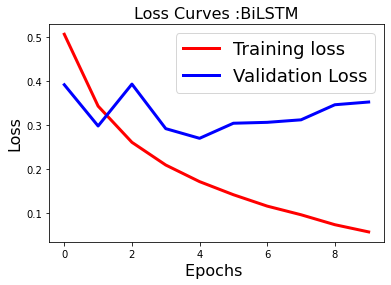

In [ ]:
fig1 = plt.figure()
plt.plot(history_bilstm.history['loss'],'r',linewidth=3.0)
plt.plot(history_bilstm.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :BiLSTM',fontsize=16)
fig1.savefig('loss_bilstm.png')
plt.show()

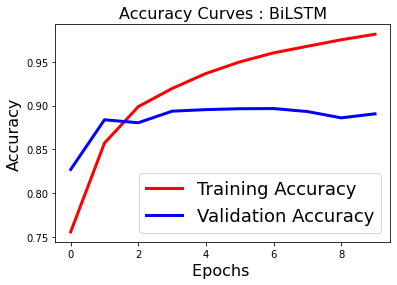

In [ ]:
fig2=plt.figure()
plt.plot(history_bilstm.history['acc'],'r',linewidth=3.0)
plt.plot(history_bilstm.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : BiLSTM',fontsize=16)
fig2.savefig('accuracy_bilstm.png')
plt.show()

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)
l_flat = Flatten()(l_pool3)
l_dropout = Dropout(0.5)(l_flat)
l_dense = Dense(128, activation='relu')(l_dropout)
preds = Dense(2, activation='softmax')(l_dense)

model_cnn = Model(sequence_input, preds)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model_cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         11380100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           8204

In [ ]:
print("model fitting - Simplified CNN")
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history_cnn = model_cnn.fit(x_train, y_train, 
          validation_data=(x_val,y_val),
          epochs=10,batch_size=64,callbacks=[cp])

model fitting - Simplified CNN


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 267s 13ms/step - loss: 0.3618 - acc: 0.8232 - val_loss: 0.6993 - val_acc: 0.7414

Epoch 00001: val_acc improved from -inf to 0.74140, saving model to model_rnn.hdf5
Epoch 2/10
20000/20000 [==============================] - 271s 14ms/step - loss: 0.1874 - acc: 0.9292 - val_loss: 0.2924 - val_acc: 0.8850

Epoch 00002: val_acc improved from 0.74140 to 0.88500, saving model to model_rnn.hdf5
Epoch 3/10
20000/20000 [==============================] - 264s 13ms/step - loss: 0.1405 - acc: 0.9518 - val_loss: 0.4452 - val_acc: 0.8838

Epoch 00003: val_acc did not improve from 0.88500
Epoch 4/10
20000/20000 [==============================] - 267s 13ms/step - loss: 0.1075 - acc: 0.9642 - val_loss: 0.5014 - val_acc: 0.8812

Epoch 00004: val_acc did not improve from 0.88500
Epoch 5/10
20000/20000 [==============================] - 265s 13ms/step - loss: 0.0794 - acc: 0.9752 - val_loss: 0.5418 -

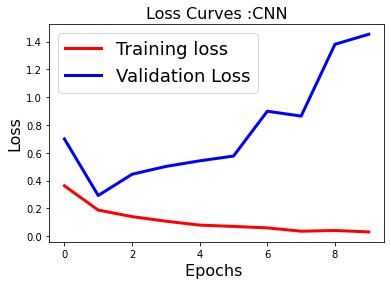

In [ ]:
fig3 = plt.figure()
plt.plot(history_cnn.history['loss'],'r',linewidth=3.0)
plt.plot(history_cnn.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig3.savefig('loss_cnn.png')
plt.show()

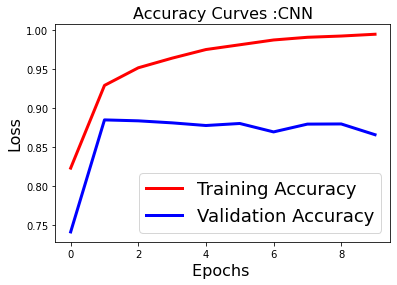

In [ ]:
fig4 = plt.figure()
plt.plot(history_cnn.history['acc'],'r',linewidth=3.0)
plt.plot(history_cnn.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Accuracy Curves :CNN',fontsize=16)
fig4.savefig('accuracy_cnn.png')
plt.show()